# Task 2 - Build Time Series Forecasting Models

import dependencies

In [7]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sys.path.append('..')
import numpy as np
from src.model_preprocessing import split_data,fit_optimized_arima,prepare_lstm_data,build_lstm,get_metrics



load the data from task 1

In [4]:
import pandas as pd 
df = pd.read_csv('../data/raw/stock_data_cleaned.csv', index_col='Date', parse_dates=True)
train_df, test_df = split_data(df['TSLA'])


plot and fit the arima

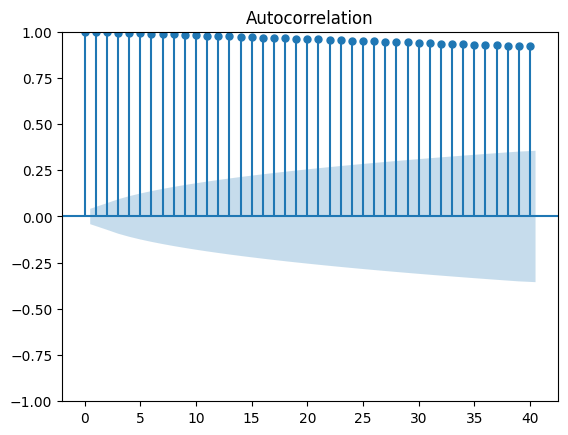

Finding best ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14030.013, Time=7.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14028.054, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14027.854, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14027.925, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14026.560, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14028.187, Time=1.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 9.883 seconds


c:\Users\arwa\portfolio-optimization\venv_task2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\arwa\portfolio-optimization\venv_task2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [5]:
plot_acf(train_df, lags=40)
plt.show()

arima_model = fit_optimized_arima(train_df)
arima_preds = arima_model.predict(n_periods=len(test_df))



In [8]:
X_train, y_train, scaler = prepare_lstm_data(train_df)
lstm_model = build_lstm((X_train.shape[1], 1), neurons=64, layers=3) 
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

inputs = pd.concat((train_df.tail(60), test_df), axis=0).values.reshape(-1, 1)
inputs = scaler.transform(inputs)
X_test = [inputs[i-60:i, 0] for i in range(60, len(inputs))]
X_test = np.reshape(np.array(X_test), (len(X_test), 60, 1))
lstm_preds = scaler.inverse_transform(lstm_model.predict(X_test))



c:\Users\arwa\portfolio-optimization\venv_task2\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step


   Model        MAE        RMSE    MAPE
0  ARIMA  96.252562  126.670725  27.97%
1   LSTM  18.445535   24.192679   6.30%


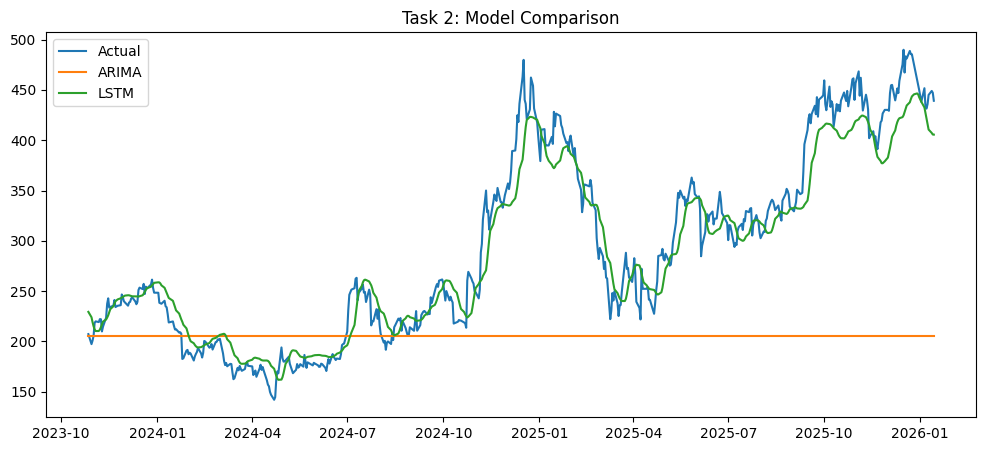

In [9]:
results = [
    get_metrics(test_df.values, arima_preds, "ARIMA"),
    get_metrics(test_df.values, lstm_preds.flatten(), "LSTM")
]
print(pd.DataFrame(results))

plt.figure(figsize=(12,5))
plt.plot(test_df.index, test_df.values, label="Actual")
plt.plot(test_df.index, arima_preds, label="ARIMA")
plt.plot(test_df.index, lstm_preds, label="LSTM")
plt.legend()
plt.title("Task 2: Model Comparison")
plt.show()

In [10]:
print(f"ARIMA Order: {arima_model.order}")
print(arima_model.summary())

ARIMA Order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2220
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7012.280
Date:                Mon, 26 Jan 2026   AIC                          14026.560
Time:                        20:36:05   BIC                          14032.265
Sample:                             0   HQIC                         14028.644
                               - 2220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        32.5364      0.367     88.639      0.000      31.817      33.256
Ljung-Box (L1) (Q):                   2.20   Jarque-Bera (JB):             13723.73
Prob(Q):                